# TP 4: Improve the Metropolis-Hastings algorithm

### Author : Vincent HERFELD

## Exercise 1: Adaptive Metropolis-Hastings within Gibbs sampler

## 1A - Metropolis-Hastings within Gibbs sampler:

### Question 1:

We would like to sample from a distribution $\pi$ such that we only know it's expression up to a scaling factor :

$$
\begin{equation}
\mathrm{d}\pi(x,y) \propto \exp\left(-\frac{x^2}{a^2} - y^2 - \frac{1}{4}\left(\frac{x^2}{a^2} - y^2\right)^2\right) \mathrm{d} x \mathrm{d} y
\end{equation}
$$
 where $a>0$.
 
To do so we will first use the MCMC algorithm Metropolis-Hastings using a Markov transition kernel that only updates 1 component at a time : $

$$
\begin{equation}
P = \frac{1}{2}(P_1 + P_2)
\end{equation}
$$

where $P_i$ only updates the $i$-th component. We will also use a random walk proposal mechanism, meaning that we will consider a symmetric proposition density in our case it will be a Gaussian variable with fixed variance $\sigma_i^2$. 

So what we do is alternate between sampling $x \sim \pi(. | y)$ and $y \sim \pi(. | x)$ with probability $0.5$.

And the acceptance ratios will have the form : 

$\alpha_y(x, x_{prop}) = 1 \wedge \frac{\pi(x_{prop}, y)}{\pi(x,y)}$ and $\alpha_x(y, y_{prop}) = 1 \wedge \frac{\pi(x,y_{prop})}{\pi(x,y)}$

We will use the fact that for a fixed component the posterior density is proportional to the joint density and since we consider ratios, we can neglect the coefficient of proportionality and only consider the parts that are varying: 

$$
\begin{align}
    \log \pi(x | y) &= \log \pi(x, y) + const = -\frac{x^2}{a^2} - \frac{1}{4}\left(\left(\frac{x}{a}\right)^4 - \left(\frac{xy}{a}\right)^2\right) + const\\
    \log \pi(y | x) &= \log \pi(x, y) + const = -y^2 - \frac{1}{4}\left(y^4 - \left(\frac{xy}{a}\right)^2\right) + const
\end{align}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd

In [2]:
@jit(nopython=True)
def log_pi(x, y, a):
    return -(x/a)**2 - y**2 - 0.25*((x/a)**2 - y**2)**2

@jit(nopython=True)
def MH(z0, N_iter, sigma_1, sigma_2, a):
    Z = [z0]
    for i in range(N_iter):
        x = Z[-1][0]
        y = Z[-1][1]
        if np.random.uniform(0,1) < 0.5: #update x knowing y
            prop = np.random.normal(x, sigma_1)
            if np.random.uniform(0,1) <= np.exp(np.min(np.array([0, log_pi(prop, y, a) - log_pi(x, y, a)]))):
                x_new = prop
            else:
                x_new = x
            Z.append(np.array([x_new, y]))
        else : #update y knowing x
            prop = np.random.normal(y, sigma_2)
            if np.random.uniform(0,1) <= np.exp(np.min(np.array([0, log_pi(x, prop, a) - log_pi(x, y, a)]))):
                y_new = prop
            else:
                y_new = y
            Z.append(np.array([x, y_new]))
    return Z

### Question 2:

(1001, 2)


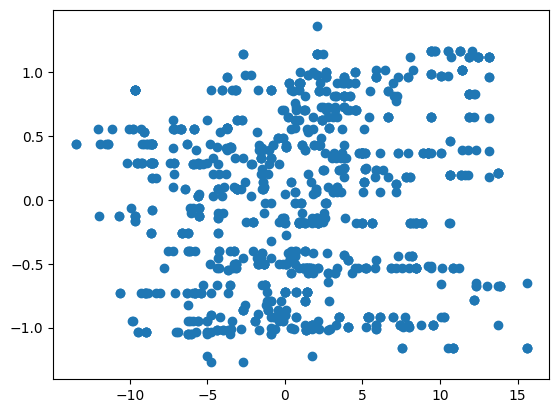

In [3]:
Z = MH(z0 = np.ones(2), N_iter = 1000, sigma_1 = 3, sigma_2 = 3, a = 10)
Z = np.array(Z)
print(Z.shape)
plt.scatter(Z[:,0],Z[:,1])
plt.show()

We notice particular horizontal lines, seeming that we get stuck for certain values of y and only modify x along the same level. Let's check the correlation between these components.

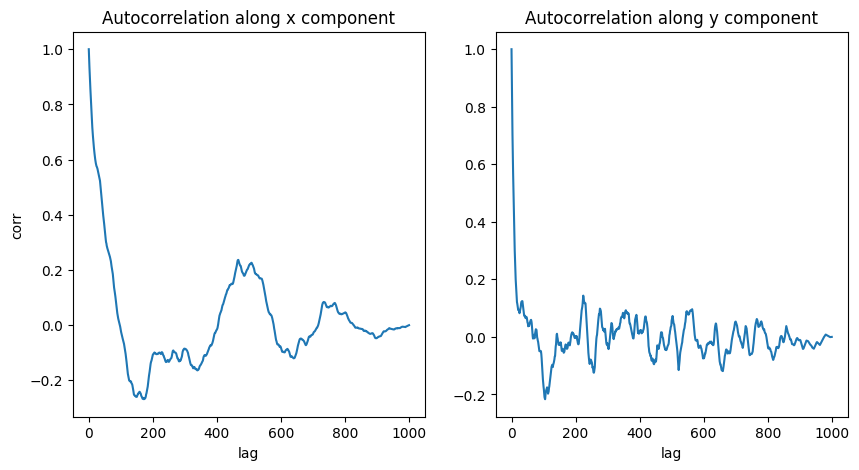

In [4]:
autocorr_x = np.correlate(Z[:, 0], Z[:, 0], mode="full")
autocorr_y = np.correlate(Z[:, 1], Z[:, 1], mode="full")

autocorr_x = autocorr_x[len(autocorr_x)//2:]
autocorr_y = autocorr_y[len(autocorr_y)//2:]

autocorr_x /= np.max(autocorr_x)
autocorr_y /= np.max(autocorr_y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(autocorr_x)
ax1.set_title("Autocorrelation along x component")
ax1.set_xlabel("lag")
ax1.set_ylabel("corr")
ax2.plot(autocorr_y)
ax2.set_title("Autocorrelation along y component")
ax2.set_xlabel("lag")
plt.show()

We notice that the autocorrelation of the components attenuates at first but then stays around a similar value.
This is something that is normal since we are sampling thanks to Markov chains that have this property on relying on the past. But in our case we would like to be able to sample independently from the target distribution, this is not the case here.

I would like to note that even though the previous algorithm resembles the Gibbs Sampler it is not one. The Gibbs sampler requires to run a MH algorithm to sample each coordinate, so 2 MH per iteration of the gibbs sampler. Here we built a version of the MH that explicits the Markov kernel as choosing between 2 coordinates. We could have built an acceptation function that considers the couple instead seperating the problem, but knowing the expression of the kernel gives us the possiblity to seperate.

### Question 3:


A first idea to improve performance would be to run the MH algorithm per sample, meaning that we only keep 1 sample per HM that has done several iterations but this is computationally costly :

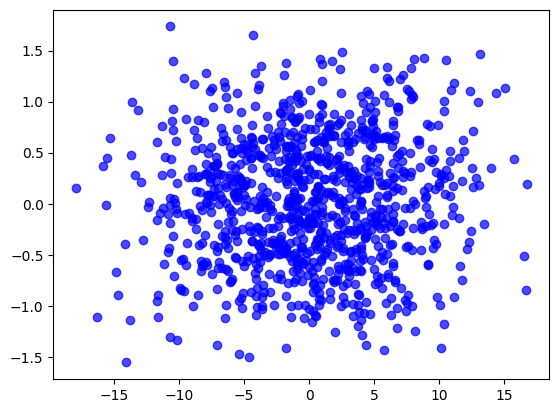

In [5]:
plt.figure()
Z = []
for i in range(1000):
    Z.append(MH(z0 = np.ones(2), N_iter = 1000, sigma_1 = 3, sigma_2 = 3, a = 10)[-1])
Z = np.array(Z)
plt.scatter(Z[:,0], Z[:,1], c ="blue", alpha=0.7)
plt.show()

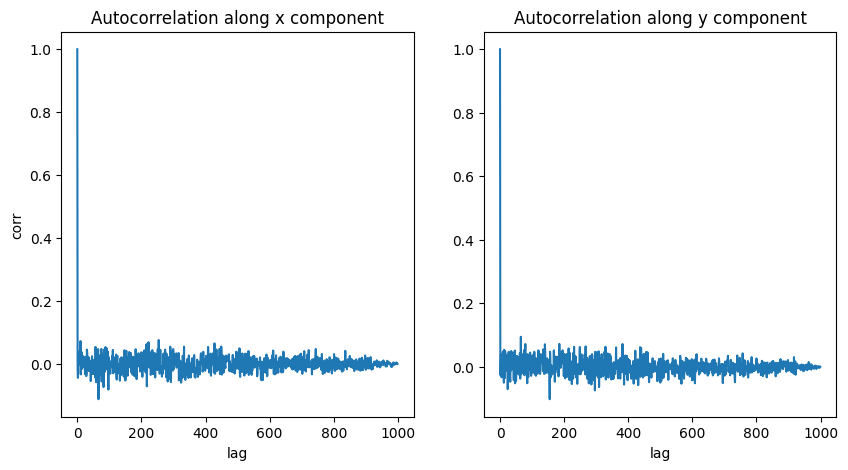

In [6]:
autocorr_x = np.correlate(Z[:, 0], Z[:, 0], mode="full")
autocorr_y = np.correlate(Z[:, 1], Z[:, 1], mode="full")

autocorr_x = autocorr_x[len(autocorr_x)//2:]
autocorr_y = autocorr_y[len(autocorr_y)//2:]

autocorr_x /= np.max(autocorr_x)
autocorr_y /= np.max(autocorr_y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(autocorr_x)
ax1.set_title("Autocorrelation along x component")
ax1.set_xlabel("lag")
ax1.set_ylabel("corr")
ax2.plot(autocorr_y)
ax2.set_title("Autocorrelation along y component")
ax2.set_xlabel("lag")
plt.show()

We don't see the lines appear.

Another way to improve the performance is that we can implement a Gibbs sampler, that will sample more independant variables. We can even implement an adaptive version where we will adapt the proposition variances to match the best acceptance rates.

## 1.B – Adaptive Metropolis-Hastings within Gibbs sampler :


### Question 1 :

Let's first implement the Gibbs sampler without adaptation.

In [486]:
@jit(nopython=True)
def log_pi_x(x, y, a):
    return -(x/a)**2 - 0.25*((x / a)**4 - (x * y / a)**2)

@jit(nopython=True)
def log_pi_y(y, x, a):
    return - y**2 - 0.25 * (- (x * y / a)**2 + y**4)

@jit(nopython=True)
def accept_x(x_new, x, y, a):
    return np.exp(np.min(np.array([0, log_pi_x(x_new, y, a) - log_pi_x(x, y, a)])))

@jit(nopython=True)
def accept_y(y_new, y, x, a):
    return np.exp(np.min(np.array([0, log_pi_y(y_new, x, a) - log_pi_y(y, x, a)])))

@jit(nopython=True)
def MH(z0, accept, param, N_iter, sigma_prop, a):
    Z = [z0]
    acc = 0
    for i in range(N_iter):
        z = Z[-1]
        prop = np.random.normal(z, sigma_prop)
        if np.random.uniform(0,1) <= accept(prop, z, param, a):
            Z.append(prop)
            acc += 1
        else:
            Z.append(z)
    return Z, acc / N_iter

#@jit(nopython = True)
def Gibbs_sampler(z0, N_iter_outer, N_iter_inner, sigma_prop, a=10):
    Z = [z0]
    Acceptance_x = []
    Acceptance_y = []
    for i in range(N_iter_outer):
        x = Z[-1][0]
        y = Z[-1][1]
        if np.random.binomial(1,0.5) == 1: #sample x first then y
            x_new, acc_x = MH(x, accept_x, y, N_iter_inner, sigma_prop, a)
            y_new, acc_y = MH(y, accept_y, x_new[-1], N_iter_inner, sigma_prop, a)
        else : #sample y first then x
            y_new, acc_y = MH(y, accept_y, x, N_iter_inner, sigma_prop, a)
            x_new, acc_x = MH(x, accept_x, y_new[-1], N_iter_inner, sigma_prop, a)
        Acceptance_x.append(acc_x)
        Acceptance_y.append(acc_y)
        Z.append([x_new[-1], y_new[-1]])
    return Z, Acceptance_x, Acceptance_y


(1001, 2)


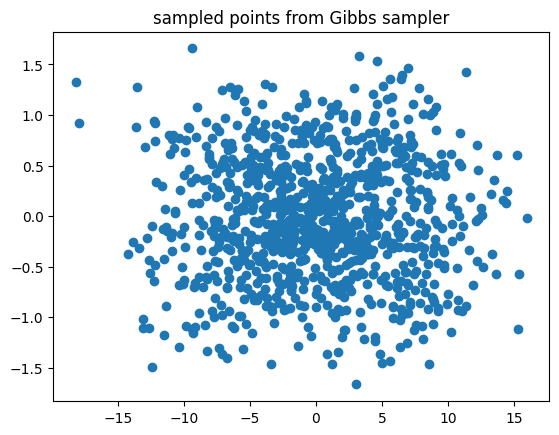

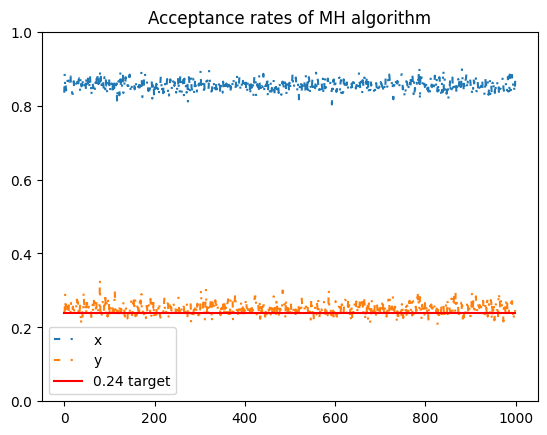

In [487]:
Z, Acceptance_x, Acceptance_y = Gibbs_sampler(z0=np.ones(2), N_iter_outer=1000, N_iter_inner=1000, sigma_prop = 3)
Z = np.array(Z)
print(Z.shape)

skip = 1
plt.scatter(Z[:,0],Z[:,1])
plt.title("sampled points from Gibbs sampler")
plt.show()

plt.figure()
plt.title("Acceptance rates of MH algorithm")
plt.plot(Acceptance_x, linestyle=(0, (3, 5, 1, 5, 1, 5)), label="x")
plt.plot(Acceptance_y, linestyle=(0, (3, 5, 1, 5, 1, 5)), label="y")
plt.plot(0.24 * np.ones(len(Acceptance_x)), c="red", label="0.24 target")
plt.ylim(0, 1)
plt.legend()
plt.show()

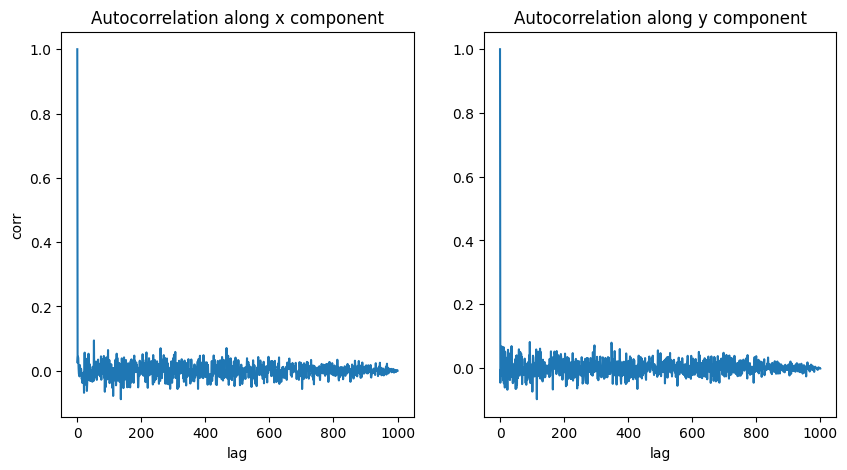

In [488]:
autocorr_x = np.correlate(Z[:, 0], Z[:, 0], mode="full")
autocorr_y = np.correlate(Z[:, 1], Z[:, 1], mode="full")

autocorr_x = autocorr_x[len(autocorr_x)//2:]
autocorr_y = autocorr_y[len(autocorr_y)//2:]

autocorr_x /= np.max(autocorr_x)
autocorr_y /= np.max(autocorr_y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(autocorr_x)
ax1.set_title("Autocorrelation along x component")
ax1.set_xlabel("lag")
ax1.set_ylabel("corr")
ax2.plot(autocorr_y)
ax2.set_title("Autocorrelation along y component")
ax2.set_xlabel("lag")
plt.show()

The correlation is better than the standard MH algorithm case, it resembles the case where we only keep the last sample from the markov chain. The problem we have is that we are not close to the "best" acceptance rate for both coordinates. We shall implement an adaptive version that changes the proposition variance during execution.

In [489]:
#@jit(nopython = True)
def Adaptive_Gibbs_sampler(z0, N_iter_outer, N_iter_inner, sigma_prop_init, a=10):
    Z = [z0]
    Acceptance_x = []
    Acceptance_y = []
    l_x = l_y = np.log(sigma_prop_init)
    b = 0
    j = 0
    for i in range(N_iter_outer):
        x = Z[-1][0]
        y = Z[-1][1]
        if b == 50:
            j += 1
            dj = np.min(np.array([0.01, j**(-0.5)]))
            l_x = l_x + dj * (-1)**(acc_x < 0.24)
            l_y = l_y + dj * (-1)**(acc_y < 0.24)
            b = 0
        if np.random.binomial(1,0.5) == 1: #sample x first then y
            x_new, acc_x = MH(x, accept_x, y, N_iter_inner, np.exp(l_x), a)
            y_new, acc_y = MH(y, accept_y, x_new[-1], N_iter_inner, np.exp(l_y), a)
        else : #sample y first then x
            y_new, acc_y = MH(y, accept_y, x, N_iter_inner, np.exp(l_y), a)
            x_new, acc_x = MH(x, accept_x, y_new[-1], N_iter_inner, np.exp(l_x), a)
        Acceptance_x.append(acc_x)
        Acceptance_y.append(acc_y)
        Z.append([x_new[-1], y_new[-1]])
        b += 1
    return Z, Acceptance_x, Acceptance_y


(100001, 2)


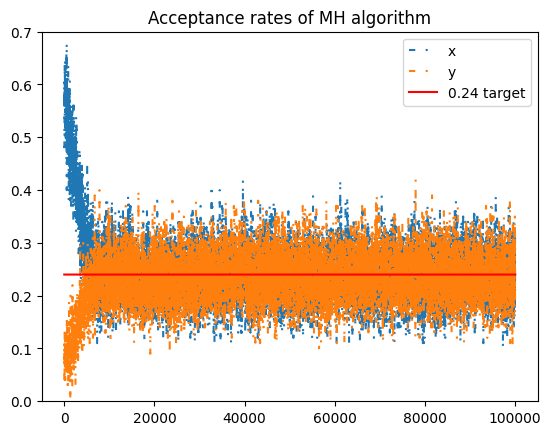

In [490]:
Z, Acceptance_x, Acceptance_y = Adaptive_Gibbs_sampler(z0=np.ones(2), N_iter_outer=100000, N_iter_inner=100, sigma_prop_init = 10)
Z = np.array(Z)
print(Z.shape)

skip = 10

plt.figure()
plt.title("Acceptance rates of MH algorithm")
plt.plot(np.arange(len(Acceptance_x))[::skip], Acceptance_x[::skip], linestyle=(0, (3, 5, 1, 5, 1, 5)), label="x")
plt.plot(np.arange(len(Acceptance_y))[::skip], Acceptance_y[::skip], linestyle=(0, (3, 5, 1, 5, 1, 5)), label="y")
plt.plot(0.24 * np.ones(len(Acceptance_x)), c="red", label="0.24 target")
plt.ylim(0, 0.7)
plt.legend()
plt.show()

In this case the algorithm reaches a best acceptance rate around 6000 iterations, let's only keep the points after that.

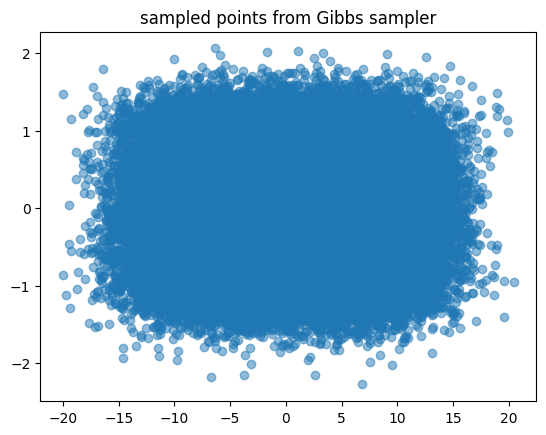

In [491]:
best_indx = 6000 
Z_best = np.array(Z[best_indx:])

skip = 1

plt.scatter(Z_best[:,0][::skip],Z_best[:,1][::skip], alpha = 0.5)
plt.title("sampled points from Gibbs sampler")
plt.show()

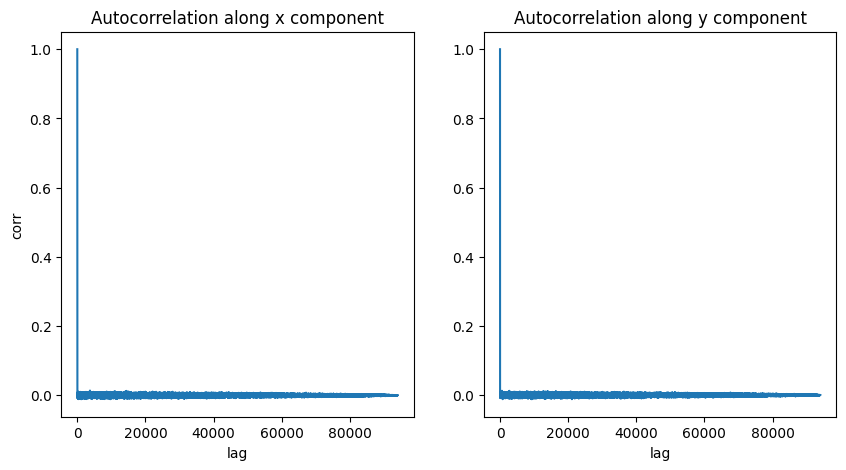

In [492]:
autocorr_x = np.correlate(Z_best[:, 0], Z_best[:, 0], mode="full")
autocorr_y = np.correlate(Z_best[:, 1], Z_best[:, 1], mode="full")

autocorr_x = autocorr_x[len(autocorr_x)//2:]
autocorr_y = autocorr_y[len(autocorr_y)//2:]

autocorr_x /= np.max(autocorr_x)
autocorr_y /= np.max(autocorr_y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(autocorr_x)
ax1.set_title("Autocorrelation along x component")
ax1.set_xlabel("lag")
ax1.set_ylabel("corr")
ax2.plot(autocorr_y)
ax2.set_title("Autocorrelation along y component")
ax2.set_xlabel("lag")
plt.show()

As we can see the algorithm is a lot better in terms of reaching the best acceptance rate

### Question 2 :

Let's now apply our method to two examples, the banana shape and a d-dimensional gaussian.

In [625]:
d = 20

@jit(nopython=True)
def accept(prop, x):    
    return np.exp(np.min(np.array([0, log_f(prop) - log_f(x)])))

@jit(nopython=True)
def MH(z0, accept, N_iter, sigma_prop, s):
    Z = [z0]  
    acc = 0
    for i in range(N_iter):
        z = Z[-1]
        prop = z.copy()
        prop[s] = np.random.normal(z[s], sigma_prop)
        if np.random.uniform(0,1) <= accept(prop, z): #accept the proposition or not
            Z.append(prop)
            acc += 1
        else:
            Z.append(z)
    return Z, acc / N_iter

#@jit(nopython = True)
def Adaptive_Gibbs_sampler(z0, N_iter_outer, N_iter_inner, sigma_prop_init):
    Z = [z0]
    d = z0.shape[0]
    Acceptance = []
    l = np.log(sigma_prop_init)
    b = 0
    j = 0
    order = np.arange(d)
    for i in range(N_iter_outer):
        z = Z[-1]
        if b == 50: #every batch of 50 apply adaptive strategy
            j += 1
            dj = np.min(np.array([0.01, j**(-0.5)]))
            for s in range(d):
                l[s] = l[s] + dj * (-1)**(acc[s] < 0.24)
            b = 0
        np.random.shuffle(order)
        new_z = z.copy()
        acc = np.empty_like(z)
        for s in order: #sample each variable conditionnaly to the others in a random order
            new_Z, acc[s] = MH(new_z, accept, N_iter_inner, np.exp(l[s]), s)
            new_z[s] = new_Z[-1][s]
        Z.append(new_z)
        Acceptance.append(acc)
        b += 1
    return Z, Acceptance

(10001, 20)


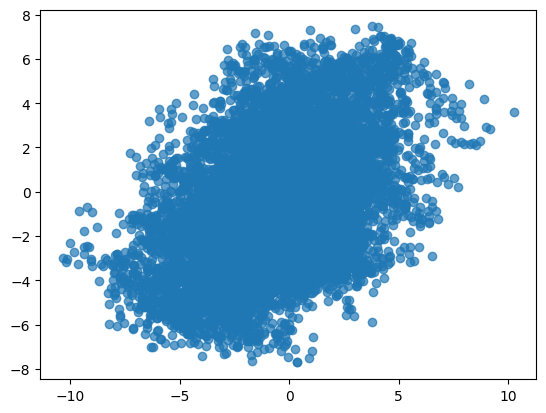

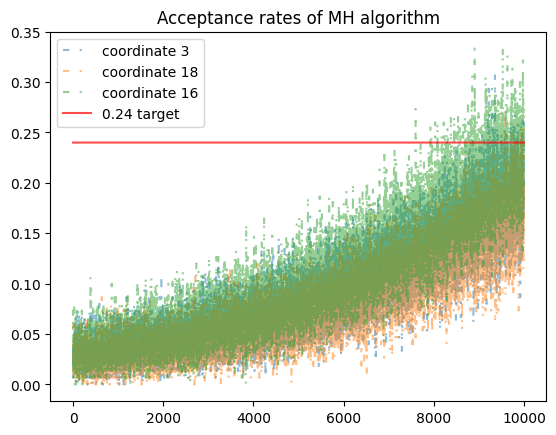

In [515]:
cov = np.empty((d,d))

with open('tmalaexcov.txt', 'r') as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    cov[i] = [float(val) for val in line.split()]
    
logdet_cov = np.linalg.slogdet(cov)[1]
inv_cov = np.linalg.inv(cov)

@jit(nopython=True)
def log_f(x): #gaussian log density
    return -0.5* x.T @ inv_cov @ x - d/2 * np.log(2*np.pi) - logdet_cov

@jit(nopython=True)
def accept(prop, x):    
    return np.exp(np.min(np.array([0, log_f(prop) - log_f(x)])))

d = 20
Z, Acceptance = Adaptive_Gibbs_sampler(2*np.ones(d), 10000, 150, 20*np.ones(d))
Z = np.array(Z)
Acceptance = np.array(Acceptance)
print(Z.shape)
plt.scatter(Z[:,0], Z[:,1], alpha = 0.7)

plt.figure()
plt.title("Acceptance rates of MH algorithm")

skip = 1 #number of points to skip to have a lighter plot
order = np.arange(d)
np.random.shuffle(order)
for s in order[:3]:
    plt.plot(np.arange(len(Acceptance[:,s]))[::skip], Acceptance[:, s][::skip], linestyle=(0, (3, 5, 1, 5, 1, 5)), alpha = 0.5, label=f"coordinate {s}")

plt.plot(0.24 * np.ones(len(Acceptance[:,0])), c="red", alpha = 0.7, label="0.24 target")
plt.legend()
plt.show()

(10001, 20)


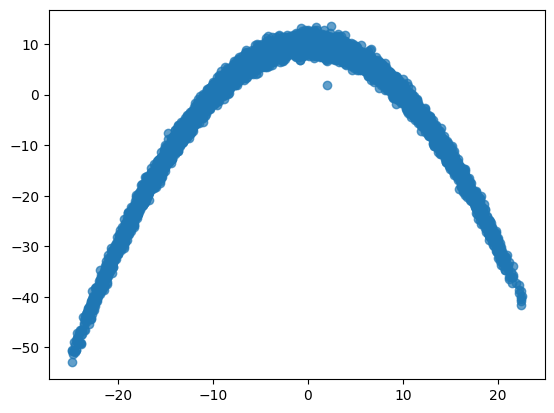

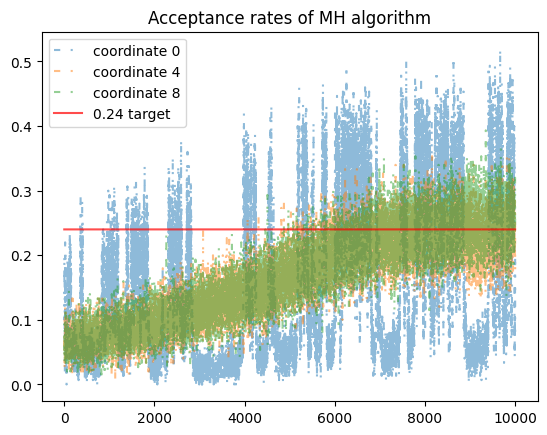

In [514]:
B = 0.1

@jit(nopython=True)
def log_f(x): #banana density
    return -(x[0]**2 / 200 + 0.5*(x[1] + B*x[0]**2 - 100*B)**2 + 0.5*(np.sum(x[2:]**2)))

@jit(nopython=True)
def accept(prop, x):    
    return np.exp(np.min(np.array([0, log_f(prop) - log_f(x)])))

d = 20
Z, Acceptance = Adaptive_Gibbs_sampler(2*np.ones(d), 10000, 150, 20*np.ones(d))
Z = np.array(Z)
Acceptance = np.array(Acceptance)
print(Z.shape)
plt.scatter(Z[:,0], Z[:,1], alpha = 0.7)

plt.figure()
plt.title("Acceptance rates of MH algorithm")

skip = 1 #number of points to skip to have a lighter plot
order = np.arange(d)
np.random.shuffle(order)
for s in order[:3]:
    plt.plot(np.arange(len(Acceptance[:,s]))[::skip], Acceptance[:, s][::skip], linestyle=(0, (3, 5, 1, 5, 1, 5)), alpha = 0.5, label=f"coordinate {s}")

plt.plot(0.24 * np.ones(len(Acceptance[:,0])), c="red", alpha = 0.7, label="0.24 target")
plt.legend()
plt.show()

## Exercise 2: Sampling from multimodal distributions

## 2.A – A toy example :

### Question 1 and 2:

In [246]:
w = 0.05
sigma = 0.1
mu = np.array([[2.18, 5.76], [8.67, 9.59], [4.24, 8.48], [8.41, 1.68], [3.93, 8.82],
               [3.25, 3.47], [1.70, 0.50], [4.59, 5.60], [6.91, 5.81], [6.87, 5.40],
               [5.41, 2.65], [2.70, 7.88], [4.98, 3.70], [1.14, 2.39], [8.33, 9.50],
               [4.93, 1.50], [1.83, 0.09], [2.26, 0.31], [5.54, 6.86], [1.69, 8.11]]).reshape(-1,2)

@jit(nopython=True)
def log_f(x):
    cum_sum = 0
    for m in mu:
        cum_sum += np.exp(- np.linalg.norm(x - m)/(2 * sigma**2))
    return np.log(w) - np.log(sigma * np.sqrt(2*np.pi)) + np.log(cum_sum)

@jit(nopython=True)
def accept(prop, x):    
    return np.exp(np.min(np.array([0, log_f(prop) - log_f(x)])))

@jit(nopython=True)
def MH(z0, accept, N_iter, sigma_prop, s):
    Z = [z0]  
    acc = 0
    for i in range(N_iter):
        z = Z[-1]
        prop = z.copy()
        prop[s] = np.random.normal(z[s], sigma_prop)
        if np.random.uniform(0,1) <= accept(prop, z):
            Z.append(prop)
            acc += 1
        else:
            Z.append(z)
    return Z, acc / N_iter

#@jit(nopython = True)
def Adaptive_Gibbs_sampler(z0, N_iter_outer, N_iter_inner, sigma_prop_init):
    Z = [z0]
    d = z0.shape[0]
    Acceptance = []
    l = np.log(sigma_prop_init)
    b = 0
    j = 0
    order = np.arange(d)
    for i in range(N_iter_outer):
        z = Z[-1]
        if b == 50:
            j += 1
            dj = np.min(np.array([0.01, j**(-0.5)]))
            for s in range(d):
                l[s] = l[s] + dj * (-1)**(acc[s] < 0.24)
            b = 0
        np.random.shuffle(order)
        new_z = z.copy()
        acc = np.empty_like(z)
        for s in order:
            new_Z, acc[s] = MH(new_z, accept, N_iter_inner, np.exp(l[s]), s)
            new_z[s] = new_Z[-1][s]
        Z.append(new_z)
        Acceptance.append(acc)
        b += 1
    return Z, Acceptance

(1001, 2)


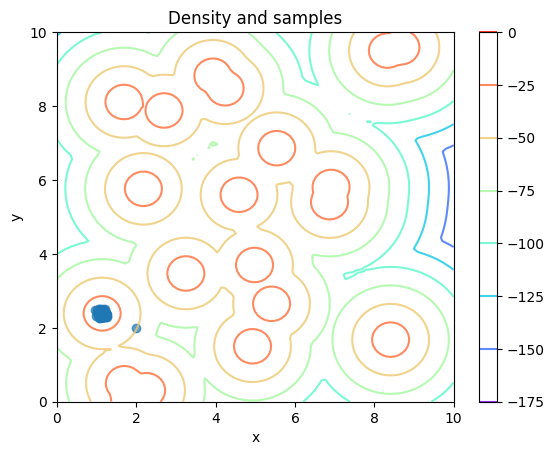

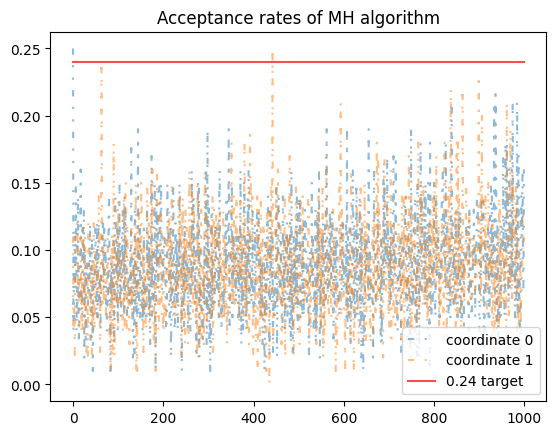

In [247]:
d = 2
Z, Acceptance = Adaptive_Gibbs_sampler(2*np.ones(d), 1000, 100, 0.5*np.ones(d))
Z = np.array(Z)
Acceptance = np.array(Acceptance)
print(Z.shape)

#plot sampled points
plt.scatter(Z[:,0], Z[:,1], alpha = 0.7)

#countour plot
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)
ZZ = []
for i in range(100):
    for j in range(100):
        ZZ.append(log_f(np.array([X[i, j], Y[i, j]])))

ZZ = np.array(ZZ).reshape(100,100)
plt.contour(X, Y, ZZ, alpha = 0.8, cmap='rainbow')
plt.colorbar()
plt.title('Density and samples')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

plt.figure()
plt.title("Acceptance rates of MH algorithm")

skip = 1 #number of points to skip to have a lighter plot
order = np.arange(d)
np.random.shuffle(order)
for s in order[:3]:
    plt.plot(np.arange(len(Acceptance[:,s]))[::skip], Acceptance[:, s][::skip], linestyle=(0, (3, 5, 1, 5, 1, 5)), alpha = 0.5, label=f"coordinate {s}")

plt.plot(0.24 * np.ones(len(Acceptance[:,0])), c="red", alpha = 0.7, label="0.24 target")
plt.legend()
plt.show()



As we can see we are able to correctly sample around some of the modes of the distribution but we seem to get samples that are stuck in the modes, and we do not sample correctly around other modes. We must use parallel tempering that will allow the samples to roam a little more in between the high "gravity" modes. 

## 2.B – Parallel Tempering :

### Question 1 :

In [251]:
@jit(nopython=True)
def log_f(x, t):
    cum_sum = 0
    for m in mu:
        cum_sum += np.exp(- np.linalg.norm(x - m)/(2 * sigma**2))
    return (np.log(w) - np.log(sigma * np.sqrt(2*np.pi)) + np.log(cum_sum)) * (1 / t)

@jit(nopython=True)
def accept(prop, x, t):    
    return np.exp(np.min(np.array([0, log_f(prop, t) - log_f(x, t)])))

@jit(nopython=True)
def MH(z0, accept, N_iter, sigma_prop, t):
    Z = [z0]  
    for i in range(N_iter):
        z = Z[-1]
        prop = np.array([np.random.normal(z[0], sigma_prop), np.random.normal(z[1], sigma_prop)])
        if np.random.uniform(0,1) <= accept(prop, z, t):
            Z.append(prop)
        else:
            Z.append(z)
    return Z

def Parallel_tempering(z0, N_iter, T):
    K = len(T)
    Z = [z0 * np.ones((K, 2))]
    for n in range(N_iter):
        X = Z[-1].copy()
        Y = np.empty_like(X)
        for i, t in enumerate(T):
            Y[i] = MH(X[i], accept, 1, 0.25* np.sqrt(t) , t)[-1]
        i = np.random.randint(K-1)
        j = i + 1
        if np.random.uniform(0, 1) <= np.exp(np.min(np.array([0, log_f(Y[j], T[i]) + log_f(Y[i], T[j]) - log_f(Y[i], T[i]) - log_f(Y[j], T[j])]))):
            X[i] = Y[j]
            X[j] = Y[i]
        else:
            X[i] = Y[i]
            X[j] = Y[j]
        for k in range(K):
            if k == i or k == j:
                continue
            else:
                X[k] = Y[k]
        Z.append(X)
    return Z

In [252]:
d = 2
T = np.array([60, 21.6, 7.7, 2.8, 1])
Z = Parallel_tempering(5, N_iter = 50000, T=T)

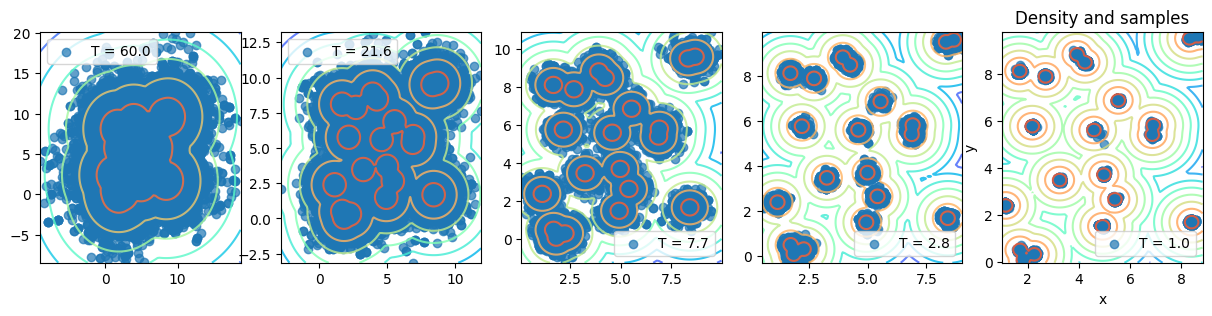

In [250]:
Z = np.array(Z)



#plot sampled points
fig, axs = plt.subplots(1, 5, figsize= (15, 3))

for i,ax in enumerate(axs):
    ax.scatter(Z[:, i, 0], Z[:, i, 1], alpha = 0.7, label=f"T = {T[i]}")
    ZZ = []
    x = np.linspace(np.min(Z[:, i, 0]), np.max(Z[:, i, 0]), 100)
    y = np.linspace(np.min(Z[:, i, 1]), np.max(Z[:, i, 1]), 100)
    X, Y = np.meshgrid(x, y)
    for ii in range(100):
        for jj in range(100):
            ZZ.append(log_f(np.array([X[ii, jj], Y[ii, jj]]), T[i]))

    ZZ = np.array(ZZ).reshape(100,100)
    ax.contour(X, Y, ZZ, alpha = 0.8, cmap='rainbow')

    ax.legend()

#countour plot

#plt.colorbar()
plt.title('Density and samples')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

Looking at the farther right plot, we have our new sampling for the original distribution (T = 1), we are happy with it since we have correctly sampled from the multi-modal distribution.

## Exercise 3: Bayesian analysis of a one-way random effects model

### Question 1:

We will use Bayes law to answer this question : 

$$
\begin{align*}
\pi_{posterior}(\mu, \sigma^2, \tau^2, X | Y) &= \frac{p(Y | \mu, \sigma^2, \tau^2, X)p(\mu, \sigma^2, \tau^2, X)}{p(Y)}\\
                            &\propto p(Y | \mu, \sigma^2, \tau^2, X)p(X | \mu, \sigma^2, \tau^2)p(\mu, \sigma^2, \tau^2)\\
                            &\propto \left( \prod_{i = 1}^{N} \mathcal{N}(X_i\mathbf{1}_{k_i}, \tau^2I_{k_i})(Y_i)\right) \times  \mathcal{N}(\mu \mathbf{1}_N, \sigma^2 I_N)(X)  \times \pi_{prior}(\mu, \sigma^2, \tau^2)
\end{align*}
$$

with $\forall i, \; Y_i = (Y_{i,j})_{j\in\{1,..,k_i\}}$ and $\{Y_i, \forall i \in \{1,...,N\}\}$ is a family of independant random vectors.

By developping an removing multiplicative constants we obtain :

$$
\begin{align*}
\pi_{posterior}(\mu, \sigma^2, \tau^2, X | Y) &\propto \frac{1}{\sigma^{2(1+\alpha) + N}}\exp\left(-\frac{1}{2\sigma^2} \left(\sum_{i=1}^{N}(X_i - \mu)^2 + 2\beta \right)\right) \frac{1}{\tau^{2(1+\gamma) + \sum_{i=1}^N} k_i}\exp\left(-\frac{1}{2\tau^2} \left(\sum_{i=1}^{N}\sum_{j=1}^{k_i}(Y_{i,j} - X_i)^2 + 2\beta \right)\right) 
\end{align*}
$$

We also recall that there are implicit indicator on $\mathbb{R}+$ functions for $\sigma^2$ and $\tau^2$ that will be usefull to recognize Inverse-Gamma distributions. 

Now to simplify the problem and to avoid using an MCMC method to estimate the parameters, we can consider the conditional densities :

$$
\begin{align*}
\pi_{posterior}(\mu| \sigma^2, \tau^2, X, Y) &\propto exp(-\frac{N}{2\sigma^2}(\bar{X} - \mu)^2) \Rightarrow \mu \sim \mathcal{N}(\bar{X}, \frac{\sigma^2}{N}) \text{ where } \bar{X} = \frac{1}{N}\sum_{i=1}^{N}X_i\\
\pi_{posterior}(\sigma ^2| \mu, \tau^2, X, Y) &\propto \frac{1}{(\sigma^2)^{1 + \alpha + N/2}}\exp\left(-\frac{\frac{1}{2} \left(\sum_{i=1}^{N}(X_i - \mu)^2 + 2\beta \right)}{\sigma^2}\right)\mathbb{1}_{\mathbb{R}+}(\sigma^2) \Rightarrow \sigma^2 \sim \textit{Inverse-Gamma}\left(\alpha + \frac{N}{2}, \frac{1}{2} \left(\sum_{i=1}^{N}(X_i - \mu)^2 + 2\beta \right)\right)\\
\pi_{posterior}(\tau ^2| \mu, \sigma^2, X, Y) &\propto \frac{1}{(\tau^2)^{1 + \gamma + \frac{1}{2}\sum_{i=1}^{N}k_i}}\exp\left(-\frac{\frac{1}{2} \left(\sum_{i=1}^{N}\sum_{j=1}^{k_i}(Y_{i,j} - X_i)^2 + 2\beta \right)}{\sigma^2}\right)\mathbb{1}_{\mathbb{R}+}(\tau^2) \Rightarrow \tau^2 \sim \textit{Inverse-Gamma}\left(\gamma + \frac{1}{2}\sum_{i=1}^{N}k_i, \frac{1}{2} \left(\sum_{i=1}^{N}\sum_{j=1}^{k_i}(Y_{i,j} - X_i)^2 + 2\beta \right)\right)\\
\pi_{posterior}(X | \mu, \sigma^2, \tau ^2, Y) &\propto \exp \left(-\frac{1}{2}\sum_{i = 1}^{N}\left(\frac{1}{\sigma^2} + \frac{k_i}{\tau^2}\right)\left(X_i - \left(\frac{\frac{\mu}{\sigma^2} + \frac{1}{\tau^2}\sum_{j=1}^{k_i}y_{i,j}}{\frac{1}{\sigma^2} + \frac{k_i}{\tau^2}}\right)\right)^2\right) \Rightarrow X \sim \mathcal{N}\left(\left(\frac{\frac{\mu}{\sigma^2} + \frac{1}{\tau^2}\sum_{j=1}^{k_i}y_{i,j}}{\frac{1}{\sigma^2} + \frac{k_i}{\tau^2}}\right)_{i=1}^N, diag(\left(\frac{1}{\sigma^2} + \frac{k_i}{\tau^2}\right)^{-1})\right)
\end{align*}
$$



### Question 2 :

Looking at the previous relations we are able to consider a Gibbs sampler that samples independantly each parameter given the previous ones.

In [811]:
from scipy.stats import invgamma

def Gibbs_sampler(z0, Y, k, N, N_iter):
    z = np.copy(z0)
    X = z[:N]
    mu = z[N]
    sigma2 = z[N+1]
    tau2 = z[N+2]
    Z = []
    for i in range(N_iter):
        #apply gibbs sampling strategy by sampling each variable conditionnaly to the others
        
        sigma2 = invgamma.rvs(a= alpha + N/2, scale= 0.5* np.sum((X - mu)**2) + beta) #sample new sigma2 value
        tau2 = invgamma.rvs(a= np.sum(k)/2 + gamma, scale= beta+np.sum((Y - X.reshape(-1,1))**2)/2)
        mu = np.random.normal(X.mean(), (sigma2/N)**0.5) #sample new mu value
        
        M = (mu / sigma2 + np.sum(Y, axis=1) / tau2) / (1 / sigma2 + k / tau2) #compute mean vector
        Cov = np.diag(1 / (1 / sigma2 + k / tau2)) #compute covariance matrix
        X = np.random.multivariate_normal(mean=M, cov = Cov) #sample new X value 
        
        #add the new variables to the trajectory
        new_z = np.empty_like(z)
        new_z[:N] = X
        new_z[N] = mu
        new_z[N+1] = sigma2
        new_z[N+2] = tau2
        
        Z.append(new_z)
    return Z

### Question 3 :

We can also implement a block Gibbs sampler which samples $\sigma^2, \tau^2$ and then the block $(X, \mu)$.

We first need the density of $(X, \mu)$ conditionnaly to the rest of the variables :

$$
\begin{align*}
\pi_{posterior}(X, \mu | \sigma^2, \tau^2, Y) &\propto \mathcal{N}(\mu', \Sigma)
\end{align*}
$$
where 

$$
\begin{align*}
\mu ' = \begin{pmatrix}\eta_1 \bar{y_1}\\. \\. \\.\\  \eta_N \bar{y_N}\\0\end{pmatrix} \text{ where } \eta_i = \frac{k_i}{\frac{\tau^2}{\sigma^2} + k_i}
\end{align*}
$$
and
$$
\begin{align*}
\Sigma^{-1} = 
\begin{pmatrix}
    \nu_1 & 0     & \dots  & 0      & -\frac{1}{\sigma^2}\\
        0 & \nu_2 & \ddots & \vdots & \vdots\\
   \vdots & \ddots& \ddots & 0      & \vdots\\
        0 & \dots & 0      & \nu_N  & -\frac{1}{\sigma^2}\\
-\frac{1}{\sigma^2}& \dots & \dots & -\frac{1}{\sigma^2} & \frac{N}{\sigma^2}\end{pmatrix}
\end{align*}
$$
with $\nu_i = (\frac{1}{\sigma^2} + \frac{k_i}{\tau^2})$ 

In [837]:
def Block_Gibbs_sampler(z0, Y, k, N, N_iter):
    z = np.copy(z0)
    X = z[:N]
    mu = z[N]
    sigma2 = z[N+1]
    tau2 = z[N+2]
    Z = []
    for i in range(N_iter):
        #sample sigma2 and tau2
        sigma2 = invgamma.rvs(a= N / 2 + alpha, scale= beta + np.sum((X - mu)**2)/2)
        tau2 = invgamma.rvs(a = gamma + np.sum(k)/2, scale = 0.5 * np.sum((Y - X.reshape(-1,1))**2) + beta)
        
        
        # sample (X,mu)
        eta = k / (tau2 / sigma2 + k)
        y = Y.mean(axis=1)
        
        M = np.zeros(N+1)
        M[:N] = eta * y
        
        diag = np.concatenate((eta, [N / sigma2]))
        Cov = np.diag(diag)
        Cov[-1,:-1] = -1/sigma2 
        Cov[:-1, -1] = -1/sigma2 
        
        temp = np.random.multivariate_normal(mean = M, cov = Cov) 
        
        #add sample to trajectory
        X, mu = temp[:N], temp[-1]
        
        new_z = np.empty_like(z)
        new_z[:N] = X
        new_z[N] = mu
        new_z[N+1] = sigma2
        new_z[N+2] = tau2
        
        Z.append(new_z)
    return Z

### Question 4:

Thinking of Gibbs and block Gibbs sampling we should have that the block Gibbs sampler is faster than the Gibbs sampler but is less efficient and accurate. 

So taking the block Gibbs sampler is a good idea when there are large amounts of data and parameters.

This said, in our setting we don't use a MCMC sampler within Gibbs so the time won in block Gibbs is negligeable since we have optimized samplers for each variable. The time will be the same for both samplers and the block version will just have less accurate results.

In conclusion the best sampler in this setting will be the standard Gibbs sampler.

### Question 5 :

In [937]:
N = 100 #number of trajectories

alpha = 1
beta = 2
gamma = 3

sigma2_real = invgamma.rvs(a=alpha, scale=beta)
tau2_real =  invgamma.rvs(a=alpha, scale=beta)
mu_real = 1



K = 10 #number of samples per trajectory

k = K * np.ones(N).astype(int)

X_real = np.random.normal(mu_real, np.sqrt(sigma2_real), size = N).reshape(-1,1)
eps = np.random.normal(0, np.sqrt(tau2_real), size=(N , K))

Y = X_real + eps
print(Y.shape)

(100, 10)


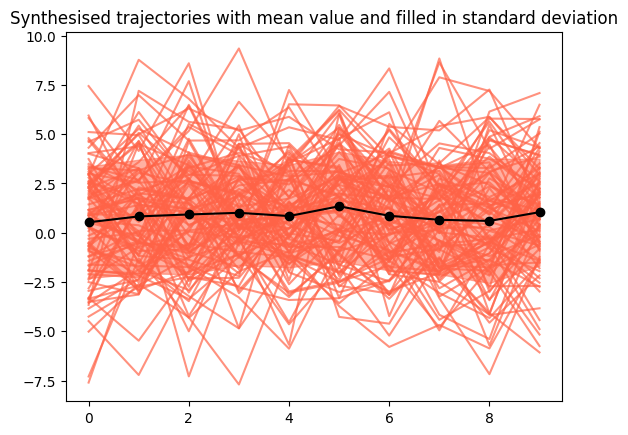

In [938]:
plt.plot(Y.T, alpha =0.7, c='tomato')
plt.plot(Y.T.mean(axis=1), marker="o",c='k')
plt.fill_between(np.arange(K), Y.T.mean(axis=1) - Y.T.std(axis=1), Y.T.mean(axis=1) + Y.T.std(axis=1), alpha=0.5, color="tomato")
plt.title("Synthesised trajectories with mean value and filled in standard deviation")
plt.show()

In [939]:
Z = Gibbs_sampler(z0 = 100*np.ones(N+3), Y=Y, k = k, N = N,  N_iter = 2000) #start from far

Z = np.array(Z)

X_est = Z[-1][:N]
mu_est = Z[-1][N]
sigma2_est = Z[-1][N+1]
tau2_est = Z[-1][N+2]

print(f"real mu  {mu_real} || estimated mu : {mu_est}")
print(f"real sigma2  {sigma2_real} || estimated sigma2 : {sigma2_est}")
print(f"real tau2  {tau2_real} || estimated tau2 : {tau2_est}")


real mu  1 || estimated mu : 0.2936031448322398
real sigma2  3.2976202632447875 || estimated sigma2 : 3.7891051864611938
real tau2  4.459641406315456 || estimated tau2 : 4.463575063648348


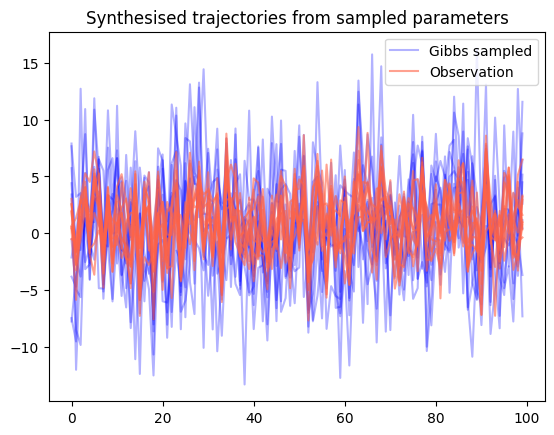

In [940]:
eps_est = np.random.normal(0, tau2_est, size=(N ,10))
Y_est = X_est.reshape(-1,1) + eps_est

fig,ax = plt.subplots()

ax.plot(Y_est, alpha =0.3, c='blue', label="Gibbs sampled")
ax.plot(Y, alpha =0.6, c='tomato', label="Observation")

ax.set_title("Synthesised trajectories from sampled parameters")

#Keep only one of each label
handles, labels = ax.get_legend_handles_labels()
unique_labels = {label: handle for handle, label in zip(handles, labels)}
ax.legend(unique_labels.values(), unique_labels.keys())

plt.show()

In [947]:
Z_block = Block_Gibbs_sampler(z0 = 1e5*np.random.normal(size=N+3), Y=Y, k = k, N = N,  N_iter = 2000) #start from far
Z_block = np.array(Z_block) 

X_est = Z_block[-1][:N]
mu_est = Z_block[-1][N]
sigma2_est = Z_block[-1][N+1]
tau2_est = Z_block[-1][N+2]
print("-----------------------------------------------------")

print(f"real mu  {mu_real} || block estimated mu : {mu_est}")
print(f"real sigma2  {sigma2_real} || block estimated sigma2: {sigma2_est}")
print(f"real tau2  {tau2_real} || block estimated tau2 : {tau2_est}")


eps_est = np.random.normal(0, tau2_est, size=(N ,10))
Y_est = X_est.reshape(-1,1) + eps_est


-----------------------------------------------------
real mu  1 || block estimated mu : 3.156646152155146
real sigma2  3.2976202632447875 || block estimated sigma2: 5.174365318109441
real tau2  4.459641406315456 || block estimated tau2 : 4.876569615241061


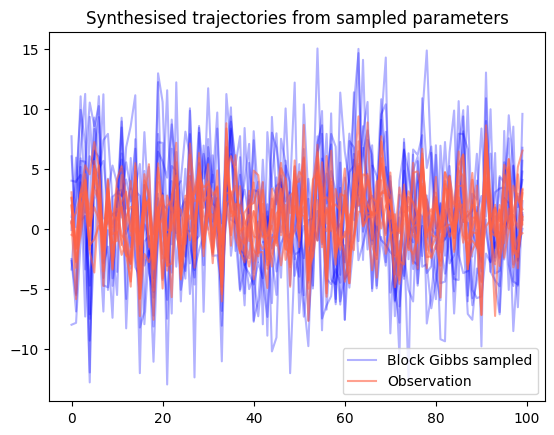

In [942]:

fig,ax = plt.subplots()

ax.plot(Y_est, alpha =0.3, c='blue', label="Block Gibbs sampled")
ax.plot(Y, alpha =0.6, c='tomato', label="Observation")

ax.set_title("Synthesised trajectories from sampled parameters")

#Keep only one of each label
handles, labels = ax.get_legend_handles_labels()
unique_labels = {label: handle for handle, label in zip(handles, labels)}
ax.legend(unique_labels.values(), unique_labels.keys())

plt.show()

We can be satisfied with the results we start from far and arrive at values of the right order of magnitude. It works very well starting closer to the real values but this is less interesting in practice.

The problem with this sampler is that there is no guarantee that the covariance stays SPD.